In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_12_months 

prec_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= last_12_months).all()
prec_data

date_pr = {}
for result in prec_data:
    date_pr[result[0]] = result[1]



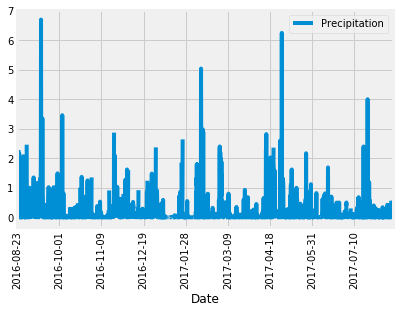

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
last

last_12_months = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_12_months

prec_data = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= last_12_months).all()
prec_data


# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(prec_data, columns=['Date', 'Precipitation'])
prec_df.set_index('Date', inplace=True)
prec_df=prec_df.sort_index()
prec_df.head()

prec_df.plot(rot=90)

# Sort the dataframe by date

#Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()


9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
station_numbers = active_stations[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station ==station_numbers).all()


[(54.0, 71.66378066378067, 85.0)]

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == station_numbers).\
                filter(Measurement.date >= last_12_months).all()
high_df = pd.DataFrame(highest_temp)
high_df.set_index('station',)
high_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

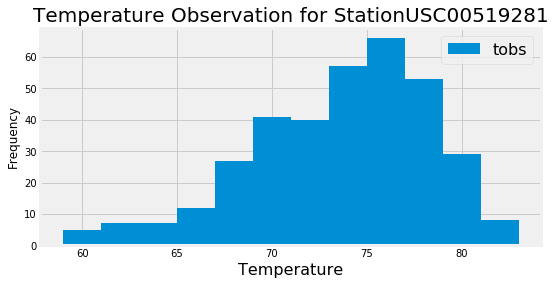

In [17]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_df.plot.hist(by='station', bins=12, figsize=(8,4))
plt.grid(True)
plt.title("Temperature Observation for Station" + station_numbers, fontsize=20)
plt.xlabel("Temperature", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)

plt.show

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-02-28', '2017-03-05')
trip_temps

[(64.0, 72.02777777777777, 78.0)]

<function matplotlib.pyplot.show(*args, **kw)>

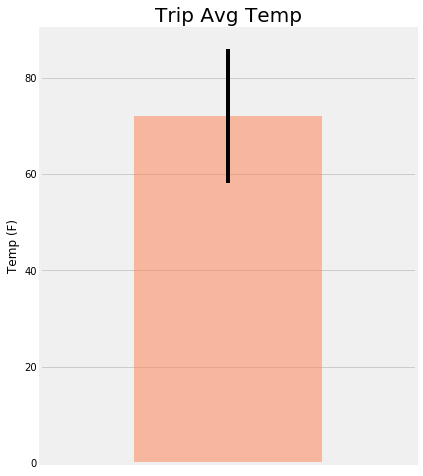

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_temp_df['Avg Temp']
min_max_temp = trip_temp_df.iloc[0]['Max Temp'] - trip_temp_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title( "Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid(True)

plt.show

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
      
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return  session.query(*sel).\
            filter(Measurement.station == Station.station).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.date <= end_date).\
            group_by(Measurement.station).\
            order_by(Measurement.prcp.desc()).all()



## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
